"메뉴"와 역까지의 "거리"를 기반으로 필터링하는 시나리오 제안

In [3]:
import sys
import os
import pandas as pd

# 현재 노트북의 디렉토리
notebook_dir = os.getcwd()

# 부모의 부모 디렉토리
grandparent_dir = os.path.dirname(os.path.dirname(notebook_dir))

# sys.path에 추가
sys.path.append(grandparent_dir)

In [4]:
from src.tools.google_drive import ensure_data_files

# 데이터 파일 경로 가져오기
data_paths = ensure_data_files()
data_paths

기존 data가 존재합니다. 파일 경로를 반환합니다.


{'reviewer': '/Users/visuworks/Desktop/쩝쩝LAB/yamyam-lab/data/reviewer.csv',
 'category': '/Users/visuworks/Desktop/쩝쩝LAB/yamyam-lab/data/diner_category_raw.csv',
 'review': '/Users/visuworks/Desktop/쩝쩝LAB/yamyam-lab/data/review.csv',
 'diner': '/Users/visuworks/Desktop/쩝쩝LAB/yamyam-lab/data/diner.csv'}

In [13]:
import ast

reviewer_df = pd.read_csv(data_paths['reviewer'])
category_df = pd.read_csv(data_paths['category'])
review_df = pd.read_csv(data_paths['review'], index_col=0)
diner_df = pd.read_csv(data_paths['diner'])
diner_df['diner_menu_name'] = diner_df['diner_menu_name'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)

/var/folders/ph/943dsflx24lbsx8rz54h45rw0000gn/T/ipykernel_5549/2345302040.py:6: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  diner_df = pd.read_csv(data_paths['diner'])


In [14]:
import math
from dataclasses import dataclass

@dataclass
class Location:
    lat: float
    lon: float

def haversine_distance(loc1: Location, loc2: Location) -> float:
    """
    Location 객체 기준 두 지점 간 거리 (단위: m)
    """
    R = 6371  # 지구 반지름 (단위: km)

    # 위도/경도를 라디안으로 변환
    phi1 = math.radians(loc1.lat)
    phi2 = math.radians(loc2.lat)
    d_phi = math.radians(loc2.lat - loc1.lat)
    d_lambda = math.radians(loc2.lon - loc1.lon)

    # Haversine 공식
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c * 1000

In [15]:
GUNJA_STATION = Location(lat=37.54969251, lon=127.0752487)

diner_df['distance'] = diner_df.apply(
    lambda row: haversine_distance(
        Location(lat=row['diner_lat'], lon=row['diner_lon']),
        GUNJA_STATION
    ),
    axis=1
)

<img src="./GunjaStation.png" width="400" height="200"/>

count     7.000000
mean     10.571429
std      11.759495
min       0.000000
25%       4.000000
50%       5.000000
75%      14.000000
max      33.000000
Name: diner_review_cnt, dtype: float64


<Axes: >

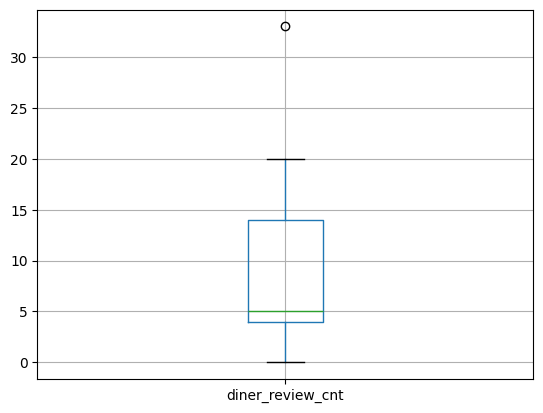

In [ ]:
menu = "마라탕"
distance = 700 # m 단위 , 대략 700m 안에 음식점 존재 (추후에 사용자 지정을 고려하면 500, 1000도 합리적일 듯)

filtered_df = diner_df[
    (diner_df['distance'] < distance) &
    (diner_df['diner_menu_name'].apply(
        lambda menu_list: any(menu in item for item in menu_list) if isinstance(menu_list, list) else False
    ))
].copy()
filtered_df['diner_review_cnt'] = pd.to_numeric(filtered_df['diner_review_cnt'], errors='coerce')

print(filtered_df['diner_review_cnt'].describe())
filtered_df[['diner_review_cnt']].boxplot()


📊 [마라탕] 리뷰 수 통계:
count     7.00
mean     10.57
std      11.76
min       0.00
25%       4.00
50%       5.00
75%      14.00
max      33.00
Name: diner_review_cnt, dtype: float64

📊 [감자탕] 리뷰 수 통계:
count    10.00
mean     13.30
std      11.37
min       0.00
25%       4.50
50%      11.50
75%      21.75
max      31.00
Name: diner_review_cnt, dtype: float64

📊 [피자] 리뷰 수 통계:
count    18.00
mean      8.94
std       7.38
min       0.00
25%       2.50
50%       7.50
75%      15.00
max      25.00
Name: diner_review_cnt, dtype: float64

📊 [치킨] 리뷰 수 통계:
count    73.00
mean      8.86
std       9.58
min       0.00
25%       2.00
50%       6.00
75%      13.00
max      45.00
Name: diner_review_cnt, dtype: float64

📊 [족발] 리뷰 수 통계:
count     5.00
mean     10.00
std      17.55
min       0.00
25%       1.00
50%       1.00
75%       7.00
max      41.00
Name: diner_review_cnt, dtype: float64


/var/folders/ph/943dsflx24lbsx8rz54h45rw0000gn/T/ipykernel_5549/2097714633.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)


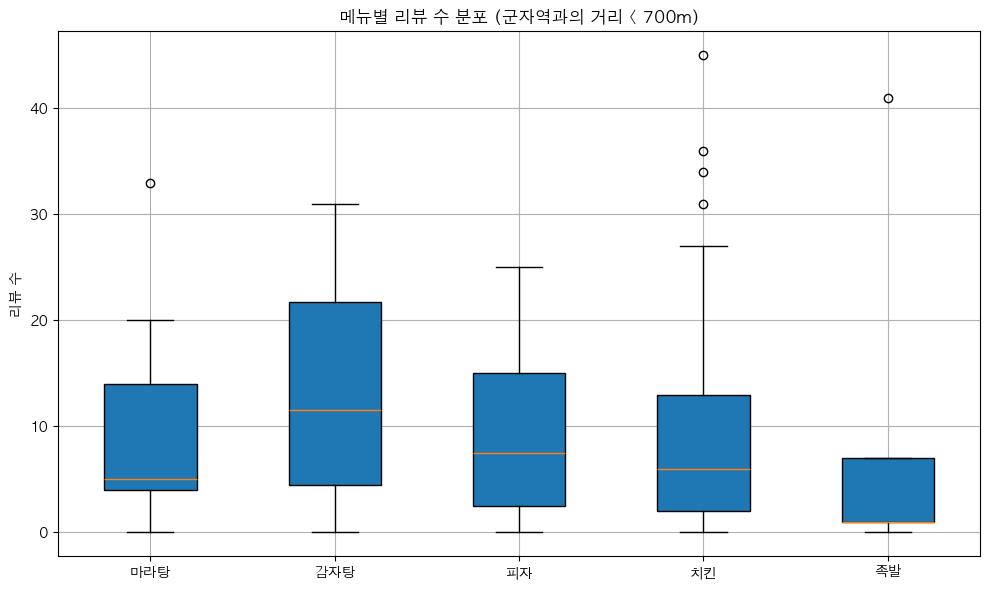

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# Apple 기본 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

menu_list = ["마라탕", "감자탕", "피자", "치킨", "족발"]
distance = 700  # m 단위

# 결과 저장용 dict
menu_stats = {}

plt.figure(figsize=(10, 6))  # 전체 박스플롯 그릴 준비
all_review_data = []  # 각 메뉴별 리뷰 수 저장
labels = []  # x축 라벨용

for menu in menu_list:
    # 필터링: 거리 + 메뉴 포함 조건
    filtered_df = diner_df[
        (diner_df['distance'] < distance) &
        (diner_df['diner_menu_name'].apply(
            lambda items: any(menu in item for item in items) if isinstance(items, list) else False
        ))
    ].copy()

    # 리뷰 수 컬럼 정리
    filtered_df['diner_review_cnt'] = pd.to_numeric(filtered_df['diner_review_cnt'], errors='coerce')

    # 통계값 저장
    stats = filtered_df['diner_review_cnt'].describe().round(2)
    menu_stats[menu] = stats

    # boxplot 준비
    all_review_data.append(filtered_df['diner_review_cnt'].dropna())
    labels.append(menu)

# 통계 출력
for menu, stats in menu_stats.items():
    print(f"\n📊 [{menu}] 리뷰 수 통계:")
    print(stats)

# 메뉴별 리뷰수 boxplot
plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)
plt.title(f"메뉴별 리뷰 수 분포 (군자역과의 거리 < {distance}m)")
plt.ylabel("리뷰 수")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 [마라탕] 리뷰 수 통계:
count     37.00
mean      36.19
std       67.08
min        1.00
25%        4.00
50%        8.00
75%       35.00
max      353.00
Name: diner_review_cnt, dtype: float64

📊 [감자탕] 리뷰 수 통계:
count    20.00
mean     22.90
std      25.99
min       0.00
25%       1.75
50%      15.50
75%      33.00
max      90.00
Name: diner_review_cnt, dtype: float64

📊 [피자] 리뷰 수 통계:
count     84.00
mean      12.74
std       22.85
min        0.00
25%        1.75
50%        6.00
75%       14.00
max      181.00
Name: diner_review_cnt, dtype: float64

📊 [치킨] 리뷰 수 통계:
count    252.00
mean      12.75
std       19.66
min        0.00
25%        3.00
50%        7.00
75%       14.00
max      181.00
Name: diner_review_cnt, dtype: float64

📊 [족발] 리뷰 수 통계:
count    27.00
mean     10.00
std      11.06
min       0.00
25%       1.00
50%       9.00
75%      13.00
max      41.00
Name: diner_review_cnt, dtype: float64


/var/folders/ph/943dsflx24lbsx8rz54h45rw0000gn/T/ipykernel_5549/3611534259.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)


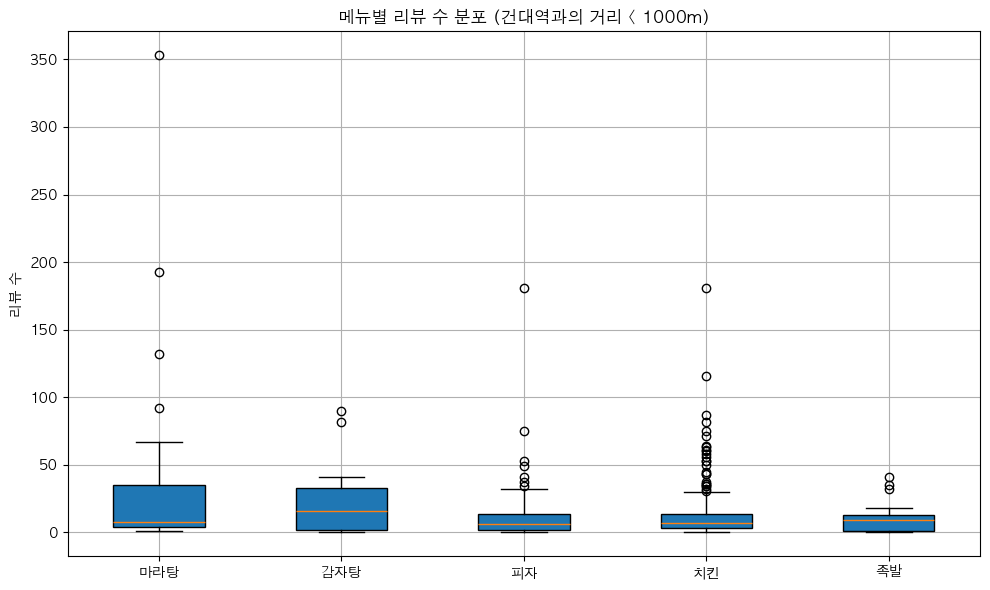

In [46]:
# 건대
GUNDAE_STATION = Location(lat=37.540451, lon=127.0747099)

diner_df['distance'] = diner_df.apply(
    lambda row: haversine_distance(
        Location(lat=row['diner_lat'], lon=row['diner_lon']),
        GUNDAE_STATION
    ),
    axis=1
)

menu_list = ["마라탕", "감자탕", "피자", "치킨", "족발"]
distance = 1000  # m 단위

# 결과 저장용 dict
menu_stats = {}

plt.figure(figsize=(10, 6))  # 전체 박스플롯 그릴 준비
all_review_data = []  # 각 메뉴별 리뷰 수 저장
labels = []  # x축 라벨용

for menu in menu_list:
    # 필터링: 거리 + 메뉴 포함 조건
    filtered_df = diner_df[
        (diner_df['distance'] < distance) &
        (diner_df['diner_menu_name'].apply(
            lambda items: any(menu in item for item in items) if isinstance(items, list) else False
        ))
    ].copy()

    # 리뷰 수 컬럼 정리
    filtered_df['diner_review_cnt'] = pd.to_numeric(filtered_df['diner_review_cnt'], errors='coerce')

    # 통계값 저장
    stats = filtered_df['diner_review_cnt'].describe().round(2)
    menu_stats[menu] = stats

    # boxplot 준비
    all_review_data.append(filtered_df['diner_review_cnt'].dropna())
    labels.append(menu)

# 통계 출력
for menu, stats in menu_stats.items():
    print(f"\n📊 [{menu}] 리뷰 수 통계:")
    print(stats)

# 메뉴별 리뷰수 boxplot
plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)
plt.title(f"메뉴별 리뷰 수 분포 (건대역과의 거리 < {distance}m)")
plt.ylabel("리뷰 수")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 [마라탕] 리뷰 수 통계:
count     18.00
mean      32.61
std       35.03
min        0.00
25%        8.50
50%       19.00
75%       48.75
max      118.00
Name: diner_review_cnt, dtype: float64

📊 [감자탕] 리뷰 수 통계:
count     24.00
mean      32.92
std       45.66
min        0.00
25%        9.25
50%       22.50
75%       29.50
max      214.00
Name: diner_review_cnt, dtype: float64

📊 [피자] 리뷰 수 통계:
count     86.00
mean      29.57
std       40.41
min        0.00
25%        5.00
50%       10.50
75%       42.25
max      179.00
Name: diner_review_cnt, dtype: float64

📊 [치킨] 리뷰 수 통계:
count    281.00
mean      26.40
std       46.64
min        0.00
25%        4.00
50%       11.00
75%       28.00
max      439.00
Name: diner_review_cnt, dtype: float64

📊 [족발] 리뷰 수 통계:
count    29.00
mean     17.14
std      18.11
min       0.00
25%       7.00
50%      12.00
75%      20.00
max      84.00
Name: diner_review_cnt, dtype: float64


/var/folders/ph/943dsflx24lbsx8rz54h45rw0000gn/T/ipykernel_5549/1271407507.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)


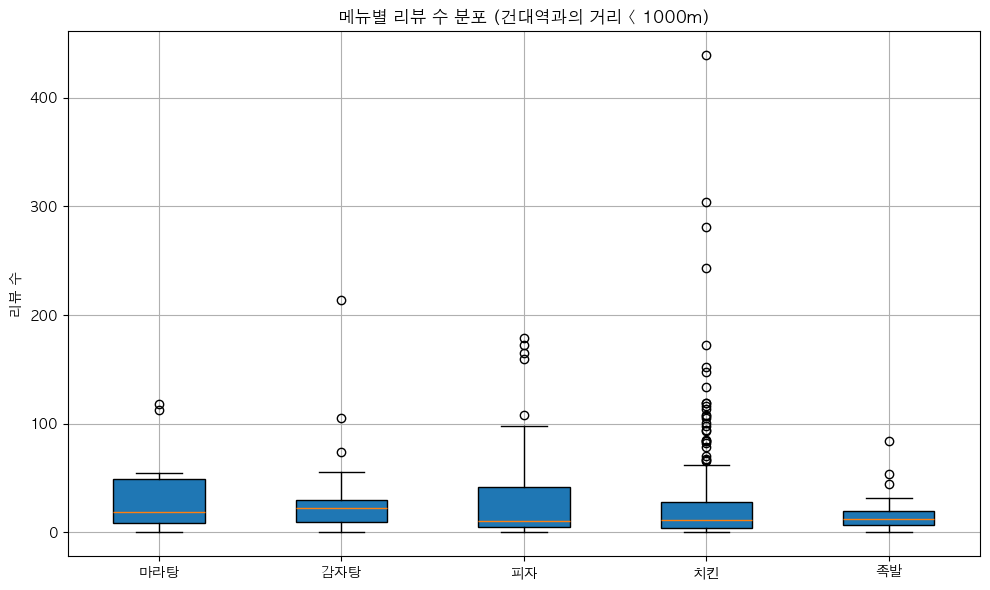

In [47]:
# 강남역
GANGNAM_STATION = Location(lat=37.498095, lon=127.027610)

diner_df['distance'] = diner_df.apply(
    lambda row: haversine_distance(
        Location(lat=row['diner_lat'], lon=row['diner_lon']),
        GANGNAM_STATION
    ),
    axis=1
)

menu_list = ["마라탕", "감자탕", "피자", "치킨", "족발"]
distance = 1000  # m 단위

# 결과 저장용 dict
menu_stats = {}

plt.figure(figsize=(10, 6))  # 전체 박스플롯 그릴 준비
all_review_data = []  # 각 메뉴별 리뷰 수 저장
labels = []  # x축 라벨용

for menu in menu_list:
    # 필터링: 거리 + 메뉴 포함 조건
    filtered_df = diner_df[
        (diner_df['distance'] < distance) &
        (diner_df['diner_menu_name'].apply(
            lambda items: any(menu in item for item in items) if isinstance(items, list) else False
        ))
    ].copy()

    # 리뷰 수 컬럼 정리
    filtered_df['diner_review_cnt'] = pd.to_numeric(filtered_df['diner_review_cnt'], errors='coerce')

    # 통계값 저장
    stats = filtered_df['diner_review_cnt'].describe().round(2)
    menu_stats[menu] = stats

    # boxplot 준비
    all_review_data.append(filtered_df['diner_review_cnt'].dropna())
    labels.append(menu)

# 통계 출력
for menu, stats in menu_stats.items():
    print(f"\n📊 [{menu}] 리뷰 수 통계:")
    print(stats)

# 메뉴별 리뷰수 boxplot
plt.boxplot(all_review_data, labels=labels, vert=True, patch_artist=True)
plt.title(f"메뉴별 리뷰 수 분포 (건대역과의 거리 < {distance}m)")
plt.ylabel("리뷰 수")
plt.grid(True)
plt.tight_layout()
plt.show()